In [9]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter, defaultdict
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import seaborn as sns 
import string
import plotly.express as px
import matplotlib.pyplot as plt 

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [11]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [29]:
pd.set_option('display.max_columns', None)
train=pd.read_csv('train.csv')  
test=pd.read_csv('test.csv')  
submission=pd.read_csv('sample_submission.csv')  

In [4]:
#counts occurences of a symbol in all the train text of an author
def symbol_counter(symbol,author):
    count=0
    for i in train[train['author']==author].tokenized_sents.values:
        for j in i:
            if j==symbol:
                count+=1

    return(count)

In [5]:
#count number of syllables in input word
def syllables(word):
    syllable_count = 0
    vowels = 'aeiouy'
    if word[0] in vowels:
        syllable_count += 1
    for index in range(1, len(word)):
        if word[index] in vowels and word[index - 1] not in vowels:
            syllable_count += 1
    if word.endswith('e'):
        syllable_count -= 1
    if word.endswith('le') and len(word) > 2 and word[-3] not in vowels:
        syllable_count += 1
    if syllable_count == 0:
        syllable_count += 1
    return syllable_count

In [17]:
train.head()

id                                               text author
0  id26305  This process, however, afforded me no means of...    EAP
1  id17569  It never once occurred to me that the fumbling...    HPL
2  id11008  In his left hand was a gold snuff box, from wh...    EAP
3  id27763  How lovely is spring As we looked from Windsor...    MWS
4  id12958  Finding nothing else, not even gold, the Super...    HPL

In [30]:
train['text_low'] = train['text'].str.lower()
train['tokenized_sents'] = train.apply(lambda raw: word_tokenize(raw['text_low']), axis=1)

group=[]
for i in train.tokenized_sents:
    group.append(" ".join(i))
train['text_all']=group

train['without_punct']=train['tokenized_sents'].apply(lambda x: [item for item in x if item not in string.punctuation])

len_all=[]
for i in train.tokenized_sents:
    len_all.append(len(i))
train['n_words']=len_all

n_words=[]
for i in train.tokenized_sents:
    res=0
    for j in i:
        res+= len(j)
    n_words.append(res)
    
train['n_character']=n_words

punct=[',','.', ';','?']
n_punct=[]
for i in train.tokenized_sents:
    res=0
    for j in i:
        if j in punct:
            res+=1
    n_punct.append(res)
    res=0
    
train['n_punct']=n_punct

train['punct_prop']=train['n_punct']/train['n_words']

punct=';'
n_punct=[]
for i in train.tokenized_sents:
    res=0
    for j in i:
        if j == punct:
            res+=1
    n_punct.append(res)
    res=0
train['semi_colon']=n_punct

punct=','
n_punct=[]
for i in train.tokenized_sents:
    res=0
    for j in i:
        if j == punct:
            res+=1
    n_punct.append(res)
    res=0
train['coma']=n_punct

punct='?'
n_punct=[]
for i in train.tokenized_sents:
    res=0
    for j in i:
        if j == punct:
            res+=1
    n_punct.append(res)
    res=0
train['interrogation']=n_punct

stop_words = set(stopwords.words('english'))
n_stop_words=[]
for i in train.tokenized_sents:
    res=0
    for j in i:
        if j in stop_words:
            res+=1
    n_stop_words.append(res)
    res=0
train['n_stop_words']=n_stop_words

train['stop_words_prop']=train['n_stop_words']/train['n_words']

n_syllabe=[]
for i in train.tokenized_sents:
    res=0
    for j in i:
        res+=syllables(j)
    n_syllabe.append(res)
    res=0
train['n_syllabe']=n_syllabe


train['pos_tags'] = train.apply(lambda row: nltk.pos_tag(row['tokenized_sents']), axis=1)

tag_count_df = pd.DataFrame(train['pos_tags'].map(lambda x: Counter(tag[1] for tag in x)).to_list())

res=pd.concat([train, tag_count_df], axis=1).fillna(0).drop(['pos_tags'], axis=1)
dropped_df = res.drop(columns = [':', ','])
train=dropped_df.iloc[:,:-27]

train['label']=train['author'].map({'EAP':2,'HPL':1, 'MWS':0})

In [31]:
train.head()

id                                               text author  \
0  id26305  This process, however, afforded me no means of...    EAP   
1  id17569  It never once occurred to me that the fumbling...    HPL   
2  id11008  In his left hand was a gold snuff box, from wh...    EAP   
3  id27763  How lovely is spring As we looked from Windsor...    MWS   
4  id12958  Finding nothing else, not even gold, the Super...    HPL   

                                            text_low  \
0  this process, however, afforded me no means of...   
1  it never once occurred to me that the fumbling...   
2  in his left hand was a gold snuff box, from wh...   
3  how lovely is spring as we looked from windsor...   
4  finding nothing else, not even gold, the super...   

                                     tokenized_sents  \
0  [this, process, ,, however, ,, afforded, me, n...   
1  [it, never, once, occurred, to, me, that, the,...   
2  [in, his, left, hand, was, a, gold, snuff, box...   
3  [how, lovely, is, spring, as, we, looked, from...   
4  [finding, nothing, else, ,, not, even, gold, ,...   

                                            text_all  \
0  this process , however , afforded me no means ...   
1  it never once occurred to me that the fumbling...   
2  in his left hand was a gold snuff box , from w...   
3  how lovely is spring as we looked from windsor...   
4  finding nothing else , not even gold , the sup...   

                                       without_punct  n_words  n_character  \
0  [this, process, however, afforded, me, no, mea...       48          191   
1  [it, never, once, occurred, to, me, that, the,...       15           58   
2  [in, his, left, hand, was, a, gold, snuff, box...       41          165   
3  [how, lovely, is, spring, as, we, looked, from...       38          173   
4  [finding, nothing, else, not, even, gold, the,...       31          148   

   n_punct  punct_prop  semi_colon  coma  interrogation  n_stop_words  \
0        7    0.145833           2     4              0            20   
1        1    0.066667           0     0              0             8   
2        5    0.121951           0     4              0            17   
3        4    0.105263           0     3              0            13   
4        4    0.129032           1     2              0            11   

   stop_words_prop  n_syllabe   DT    NN   RB  VBD  PRP  NNS   IN  VBG  PRP$  \
0         0.416667         68  6.0  10.0  3.0  2.0  1.0  2.0  5.0  2.0   2.0   
1         0.533333         20  2.0   2.0  2.0  1.0  2.0  0.0  1.0  0.0   0.0   
2         0.414634         56  5.0   9.0  1.0  3.0  2.0  1.0  6.0  1.0   1.0   
3         0.342105         55  2.0   6.0  1.0  2.0  1.0  4.0  6.0  0.0   0.0   
4         0.354839         52  2.0   6.0  4.0  1.0  1.0  1.0  3.0  2.0   3.0   

    MD   VB   CC  label  
0  1.0  1.0  1.0      2  
1  1.0  1.0  0.0      1  
2  0.0  0.0  0.0      2  
3  0.0  0.0  2.0      0  
4  0.0  0.0  1.0      1

In [196]:
test['text_low'] = test['text'].str.lower()
test['tokenized_sents'] = test.apply(lambda raw: nltk.word_tokenize(raw['text_low']), axis=1)

group=[]
for i in test.tokenized_sents:
    group.append(" ".join(i))
test['text_all']=group

test['without_punct']=test['tokenized_sents'].apply(lambda x: [item for item in x if item not in string.punctuation])

len_all=[]
for i in test.tokenized_sents:
    len_all.append(len(i))
test['n_words']=len_all

n_words=[]
for i in test.tokenized_sents:
    res=0
    for j in i:
        res+= len(j)
    n_words.append(res)
    
test['n_character']=n_words

punct=[',','.', ';','?']
n_punct=[]
for i in test.tokenized_sents:
    res=0
    for j in i:
        if j in punct:
            res+=1
    n_punct.append(res)
    res=0
    
test['n_punct']=n_punct

test['punct_prop']=test['n_punct']/test['n_words']

punct=';'
n_punct=[]
for i in test.tokenized_sents:
    res=0
    for j in i:
        if j == punct:
            res+=1
    n_punct.append(res)
    res=0
test['semi_colon']=n_punct

punct=','
n_punct=[]
for i in test.tokenized_sents:
    res=0
    for j in i:
        if j == punct:
            res+=1
    n_punct.append(res)
    res=0
test['coma']=n_punct

punct='?'
n_punct=[]
for i in test.tokenized_sents:
    res=0
    for j in i:
        if j == punct:
            res+=1
    n_punct.append(res)
    res=0
test['interrogation']=n_punct

stop_words = set(stopwords.words('english'))
n_stop_words=[]
for i in test.tokenized_sents:
    res=0
    for j in i:
        if j in stop_words:
            res+=1
    n_stop_words.append(res)
    res=0
test['n_stop_words']=n_stop_words

test['stop_words_prop']=test['n_stop_words']/test['n_words']

n_syllabe=[]
for i in test.tokenized_sents:
    res=0
    for j in i:
        res+=syllables(j)
    n_syllabe.append(res)
    res=0
test['n_syllabe']=n_syllabe


test['pos_tags'] = test.apply(lambda row: nltk.pos_tag(row['tokenized_sents']), axis=1)

tag_count_df = pd.DataFrame(test['pos_tags'].map(lambda x: Counter(tag[1] for tag in x)).to_list())

res=pd.concat([test, tag_count_df], axis=1).fillna(0).drop(['pos_tags'], axis=1)
dropped_df = res.drop(columns = [':', ','])
test=dropped_df.iloc[:,:-27]


In [197]:
test.head()

id                                               text  \
0  id02310  Still, as I urged our leaving Ireland with suc...   
1  id24541  If a fire wanted fanning, it could readily be ...   
2  id00134  And when they had broken down the frail door t...   
3  id27757  While I was thinking how I should possibly man...   
4  id04081  I am not sure to what limit his knowledge may ...   

                                            text_low  \
0  still, as i urged our leaving ireland with suc...   
1  if a fire wanted fanning, it could readily be ...   
2  and when they had broken down the frail door t...   
3  while i was thinking how i should possibly man...   
4  i am not sure to what limit his knowledge may ...   

                                     tokenized_sents  \
0  [still, ,, as, i, urged, our, leaving, ireland...   
1  [if, a, fire, wanted, fanning, ,, it, could, r...   
2  [and, when, they, had, broken, down, the, frai...   
3  [while, i, was, thinking, how, i, should, poss...   
4  [i, am, not, sure, to, what, limit, his, knowl...   

                                            text_all  \
0  still , as i urged our leaving ireland with su...   
1  if a fire wanted fanning , it could readily be...   
2  and when they had broken down the frail door t...   
3  while i was thinking how i should possibly man...   
4  i am not sure to what limit his knowledge may ...   

                                       without_punct  n_words  n_character  \
0  [still, as, i, urged, our, leaving, ireland, w...       22           92   
1  [if, a, fire, wanted, fanning, it, could, read...       69          269   
2  [and, when, they, had, broken, down, the, frai...       36          157   
3  [while, i, was, thinking, how, i, should, poss...       46          183   
4  [i, am, not, sure, to, what, limit, his, knowl...       12           43   

   n_punct  punct_prop  semi_colon  coma  interrogation  n_stop_words  \
0        3    0.136364           0     2              0             9   
1        7    0.101449           0     6              0            34   
2        2    0.055556           0     1              0            16   
3        5    0.108696           0     4              0            21   
4        1    0.083333           0     0              0             6   

   stop_words_prop  n_syllabe   RB    IN    NN  VBD  PRP$  VBG   JJ   CC  PRP  
0         0.409091         31  1.0   2.0   5.0  2.0   2.0  1.0  1.0  1.0  1.0  
1         0.492754         99  4.0  13.0  16.0  5.0   0.0  0.0  1.0  3.0  1.0  
2         0.444444         52  2.0   3.0   5.0  3.0   0.0  1.0  3.0  2.0  2.0  
3         0.456522         61  2.0   8.0   8.0  3.0   1.0  2.0  2.0  1.0  1.0  
4         0.500000         15  1.0   0.0   2.0  0.0   1.0  0.0  1.0  0.0  0.0

In [21]:
train.to_csv('train_processed.csv', index=False)
test.to_csv('test_processed.csv', index=False)

In [32]:
train_feat = train.groupby('author').mean().reset_index()
train_feat.head()

author    n_words  n_character   n_punct  punct_prop  semi_colon      coma  \
0    EAP  29.381266   118.161646  3.433924    0.123326    0.171392  2.227089   
1    HPL  30.873292   129.134871  2.765572    0.097147    0.202839  1.522804   
2    MWS  31.241893   125.485606  3.447551    0.116812    0.440437  1.992886   

   interrogation  n_stop_words  stop_words_prop  n_syllabe        DT  \
0       0.064557     13.250633         0.445382  42.371899  3.240886   
1       0.029991     13.380479         0.432265  44.197338  3.176752   
2       0.069325     14.383355         0.455579  43.974024  2.663468   

         NN        RB       VBD       PRP       NNS        IN       VBG  \
0  5.042532  1.624684  1.328354  1.051013  1.044684  3.730127  0.397468   
1  5.439574  1.632831  2.034073  1.074712  1.526531  3.760603  0.464419   
2  5.264725  1.335870  1.920582  1.538882  1.341330  3.538716  0.354732   

       PRP$        MD        VB        CC  label  
0  0.630633  0.312405  0.818861  1.002532    2.0  
1  0.542857  0.309672  0.856256  1.378172    1.0  
2  1.234116  0.447220  1.176208  1.320483    0.0

Text(0.5, 1.0, 'Number of sentences for each author')

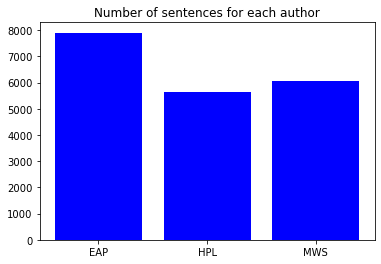

In [200]:
#check zether training data is balanced
plt.bar(train.groupby('author').count().reset_index().author, train.groupby('author').count().reset_index().id, color='b')
plt.title('Number of sentences for each author')

In [35]:
train_feat.to_csv('train_mean_features_by_author.csv', index=False)


In [51]:
# returns various features of sentences of each author,
# data input is processed train dataframe
def get_author_features(author, data):
    res_final=[]
    res_sentence_final=[]
    size_word_final=[]
    all_syllabe=[]
    for i in list(data[data['author']==author].tokenized_sents.values):
        temp = [len(ele) for ele in i]
        res = 0 if len(temp) == 0 else (float(sum(temp)) / len(temp))
        res_final.append(res)
        
        size_word_final += temp
        
        res_sentence_final.append(len(i))
        
        
        for j in i:
            all_syllabe.append(syllables(j))
        
            
    return np.mean(size_word_final), max(size_word_final), min(size_word_final), np.mean(res_sentence_final), max(res_sentence_final), min(res_sentence_final), np.mean(all_syllabe)

In [54]:
author_features = pd.DataFrame(columns = ['mean word lenghth', 'max word lenghth', 'min word lenghth','mean sentence lenghth','max sentence lenghth', 'min sentence lenghth', 'mean syllables per word'], 
                   index = ['EAP', 'HPL', 'MWS'])
author_features.loc['EAP'] = get_author_features('EAP', train)
author_features.loc['HPL'] = get_author_features('HPL', train)
author_features.loc['MWS'] = get_author_features('MWS', train)



In [55]:
author_features

mean word lenghth max word lenghth min word lenghth mean sentence lenghth  \
EAP          4.021666               53                1             29.381266   
HPL          4.182737               18                1             30.873292   
MWS          4.016581               18                1             31.241893   

    max sentence lenghth min sentence lenghth mean syllables per word  
EAP                  330                    4                 1.44214  
HPL                  169                    4                1.431572  
MWS                  876                    4                1.407534

In [58]:
#merge the text of each author, the endgoal is to get added features as frequencies per n words for each author
merge_author=train.groupby('author')['text'].apply(' '.join).reset_index()
merge_author['text_low'] = merge_author['text'].str.lower()
merge_author['tokenized_sents'] = merge_author.apply(lambda raw: nltk.word_tokenize(raw['text_low']), axis=1)
group=[]
for i in merge_author.tokenized_sents:
    group.append(" ".join(i))
merge_author['text_all']=group
merge_author

author                                               text  \
0    EAP  This process, however, afforded me no means of...   
1    HPL  It never once occurred to me that the fumbling...   
2    MWS  How lovely is spring As we looked from Windsor...   

                                            text_low  \
0  this process, however, afforded me no means of...   
1  it never once occurred to me that the fumbling...   
2  how lovely is spring as we looked from windsor...   

                                     tokenized_sents  
0  [this, process, ,, however, ,, afforded, me, n...  
1  [it, never, once, occurred, to, me, that, the,...  
2  [how, lovely, is, spring, as, we, looked, from...

In [191]:
# returns various frequencies on every n words of a tokenized sentence,
# data input is dataframe with tokenized sentences,
# and the index of the line where frequencies will be calculated

def get_author_freqs(line_index, data, n=4) :  
    stop_words = set(stopwords.words('english'))
    compare=','
    compare1=';'

    len_word=[]
    len_word_final=[]
    syllabes_ten=[]
    syllabes_ten_final=[]

    coma=0
    coma_all=[]

    point_virgule=0
    point_virgule_all=[]

    stop_word=0
    stop_words_all=[]
    
    cnt=0

    
    sentence_list = list(data.tokenized_sents.values)[line_index]

    for i in sentence_list:
        cnt+=1
        
        if len(i)>1:
            len_word.append(len(i))
            syllabes_ten.append(syllables(i))

        if i == compare:
            coma+=1

        elif i == compare1:
            point_virgule += 1

        if i in stop_words:
            stop_word+=1

        if cnt%n == 0:
            if len(len_word) !=0:
                len_word_final.append(np.mean(len_word))
            if len(syllabes_ten) !=0:
                syllabes_ten_final.append(np.sum(syllabes_ten))
            coma_all.append(coma) 
            point_virgule_all.append(point_virgule)
            stop_words_all.append(stop_word)
            len_word=[]
            syllabes_ten=[]
            coma=0
            point_virgule=0
            stop_word=0

        
     
    syllabes_ten_final = [x for x in syllabes_ten_final if str(x) != 'nan']
    return np.mean(syllabes_ten_final), np.mean(coma_all), np.mean(point_virgule_all), np.mean(stop_words_all)

In [192]:
author_frequencies = pd.DataFrame(columns = ['syllables freq', 'commas freq', 'semicolon freq','stop words freq'], 
                   index = ['EAP', 'HPL', 'MWS'])
author_frequencies.loc['EAP'] = get_author_freqs(0, merge_author)
author_frequencies.loc['HPL'] = get_author_freqs(1, merge_author)
author_frequencies.loc['MWS'] = get_author_freqs(2, merge_author)
author_frequencies

syllables freq commas freq semicolon freq stop words freq
EAP       5.143682    0.303245       0.023337        1.804133
HPL       5.214659    0.197323       0.026284        1.733783
MWS       5.030632    0.255164       0.056392        1.841542

In [198]:
test_frequencies = pd.DataFrame(columns = ['syllables freq', 'commas freq', 'semicolon freq','stop words freq'], 
                   index = test.index)
for i in test.index:
    test_frequencies.loc[i] = get_author_freqs(i, test)
test_frequencies

syllables freq commas freq semicolon freq stop words freq
0               5.2         0.4            0.0             1.8
1               5.0    0.352941            0.0             2.0
2          5.333333    0.111111            0.0        1.777778
3          4.727273    0.363636            0.0        1.909091
4          4.333333         0.0            0.0             2.0
...             ...         ...            ...             ...
8387            4.5         0.0            0.0             3.5
8388            4.5         0.0            0.0             2.0
8389       6.166667    0.166667            0.0        1.833333
8390            5.1         0.2            0.0             2.1
8391            6.4         0.4            0.0             1.9

[8392 rows x 4 columns]

In [199]:
test_all_features  = pd.concat([test,test_frequencies], axis = 1)
test_all_features.to_csv('test_features.csv', index=True)

In [185]:
author_all_features  = pd.concat([author_features,author_frequencies], axis = 1)
author_all_features.to_csv('author_features.csv', index=True)
author_all_features

mean word lenghth max word lenghth min word lenghth mean sentence lenghth  \
EAP          4.021666               53                1             29.381266   
HPL          4.182737               18                1             30.873292   
MWS          4.016581               18                1             31.241893   

    max sentence lenghth min sentence lenghth mean syllables per word  \
EAP                  330                    4                 1.44214   
HPL                  169                    4                1.431572   
MWS                  876                    4                1.407534   

    syllables freq commas freq semicolon freq stop words freq  
EAP       5.143682    0.303245       0.023337        1.804133  
HPL       5.214659    0.197323       0.026284        1.733783  
MWS       5.030632    0.255164       0.056392        1.841542

In [97]:
vectorizer = TfidfVectorizer(lowercase=True, token_pattern=r'(?u)\b\w*[a-zA-Z]\w*\b' ,analyzer='word', stop_words='english',use_idf=False, norm=False,min_df=0.01)
input_matrix = vectorizer.fit_transform(merge_author['test_all'])
df_tfidf = pd.DataFrame(input_matrix.toarray(), columns=vectorizer.get_feature_names_out())

In [98]:
df_tfidf

aaem   ab  aback  abaft  abandon  abandoned  abandoning  abandonment  \
0   1.0  1.0    2.0    0.0      7.0       11.0         2.0          2.0   
1   0.0  0.0    0.0    0.0      3.0       13.0         1.0          0.0   
2   0.0  0.0    0.0    1.0      1.0        5.0         0.0          3.0   

   abaout  abased  abasement  abashed  abashment  abate  abated  abatement  \
0     0.0     1.0        1.0      1.0        0.0    0.0     1.0        0.0   
1    24.0     0.0        0.0      0.0        1.0    2.0     0.0        1.0   
2     0.0     0.0        0.0      0.0        0.0    0.0     0.0        1.0   

   abating  abbey  abbeys  abbreviation  abbé  abdicated  abdication  \
0      1.0    2.0     1.0           2.0   1.0        0.0         1.0   
1      0.0    0.0     0.0           0.0   0.0        0.0         0.0   
2      0.0    2.0     0.0           0.0   0.0        1.0         4.0   

   abdications  abdomen  abdul  abernethy  aberrancy  aberrant  aberration  \
0          0.0      0.0    0.0        4.0        0.0       0.0         1.0   
1          0.0      1.0    5.0        0.0        1.0       2.0         0.0   
2          1.0      0.0    0.0        0.0        0.0       0.0         0.0   

   aberrations  abeyance  abhor  abhorred  abhorrence  abhorrent  abide  \
0          0.0       3.0    1.0       0.0         2.0        0.0    1.0   
1          1.0       0.0    0.0       4.0         2.0        8.0    0.0   
2          1.0       0.0    4.0       8.0         5.0        1.0    0.0   

   abigail  abijah  abilities  ability  abject  abjure  ablaze  able  ably  \
0      0.0     0.0        4.0     11.0     2.0     0.0     0.0  31.0   0.0   
1      2.0     1.0        0.0      1.0     0.0     0.0     1.0  22.0   0.0   
2      0.0     0.0        1.0      2.0     4.0     1.0     0.0  14.0   1.0   

   abnormal  abnormalities  abnormality  abnormally  aboard  abode  abodes  \
0       4.0            0.0          0.0         2.0     0.0    0.0     0.0   
1      17.0            3.0          6.0         3.0     2.0   10.0     2.0   
2       0.0            0.0          0.0         0.0     0.0   29.0     4.0   

   abolished  abominable  abomination  abominations  aboriginal  abortion  \
0        1.0         2.0          0.0           0.0         1.0       0.0   
1        0.0         1.0          2.0           2.0         0.0       0.0   
2        0.0         0.0          0.0           0.0         0.0       1.0   

   abortions  abortive  abounded  aboundingly  abounds  abra  abreast  abroad  \
0        2.0       1.0       1.0          0.0      2.0   0.0      0.0     5.0   
1        0.0       0.0       0.0          1.0      0.0   0.0      2.0    10.0   
2        0.0       1.0       0.0          0.0      0.0   2.0      0.0     1.0   

   abrupt  abruptly  abruptness  absconded  absence  absences  absense  \
0     2.0       7.0         0.0        1.0     25.0       0.0      0.0   
1     1.0      10.0         1.0        0.0      6.0       1.0      1.0   
2     2.0       4.0         2.0        0.0     35.0       1.0      0.0   

   absent  absolute  absolutely  absolved  absorb  absorbed  absorbing  \
0     6.0      24.0        33.0       1.0     0.0      17.0        2.0   
1     4.0       7.0         7.0       0.0     1.0       3.0        1.0   
2    13.0       2.0         2.0       0.0     0.0       5.0        2.0   

   absorbingly  absorption  abstain  abstained  abstaining  abstemious  \
0          0.0         0.0      0.0        0.0         0.0         0.0   
1          1.0         1.0      0.0        0.0         0.0         0.0   
2          0.0         0.0      1.0        1.0         1.0         1.0   

   abstract  abstracted  abstraction  abstractions  abstractly  abstruse  \
0       6.0         2.0          7.0           1.0         1.0       1.0   
1       1.0         0.0          0.0           0.0         0.0       0.0   
2       0.0         1.0          1.0           0.0         0.0       2.0   

   abstruseness  absurd  absur

In [26]:
df_tfidf.iloc[0:1,np.argmax(list(df_tfidf.iloc[0:1,].values[0])):np.argmax(list(df_tfidf.iloc[0:1,].values[0]))+1].columns[0],max(list(df_tfidf.iloc[0:1,].values[0]))

('s', 410.0)

In [27]:
df_tfidf.iloc[1:2,np.argmax(list(df_tfidf.iloc[1:2,].values[0])):np.argmax(list(df_tfidf.iloc[1:2,].values[0]))+1].columns[0],max(list(df_tfidf.iloc[1:2,].values[0]))

('s', 626.0)

In [28]:
df_tfidf.iloc[2:3,np.argmax(list(df_tfidf.iloc[2:3,].values[0])):np.argmax(list(df_tfidf.iloc[2:3,].values[0]))+1].columns[0],max(list(df_tfidf.iloc[2:3,].values[0]))

('s', 352.0)

In [100]:
usa=list(df_tfidf.iloc[0:1].values[0])

index=0
list_index=[]
for i in df_tfidf.iloc[0:1].values[0]:
    if i in sorted(usa, reverse=True)[:10]:
        list_index.append(index)
    index+=1
    
list_usa=df_tfidf.iloc[0:1,list_index]

KeyboardInterrupt: 

In [65]:
english=list(df_tfidf.iloc[2:3].values[0])

index=0

In [67]:
list_index=[]
for i in df_tfidf.iloc[2:3].values[0]:
    if i in sorted(english, reverse=True)[:10]:
        list_index.append(index)
    index+=1

In [68]:
list_english=df_tfidf.iloc[0:1,list_index]

In [69]:
list_english

did   eyes  heart   life  love    man  raymond      s   said   time
0  207.0  168.0   97.0  105.0  51.0  257.0      0.0  410.0  356.0  260.0

In [70]:
list_usa

did  great  having  little   long    man      s   said    say   time
0  207.0  227.0   187.0   275.0  212.0  257.0  410.0  356.0  267.0  260.0

In [101]:
## T-SNE part

In [102]:
from sklearn.manifold import TSNE

In [106]:
vectorizer = TfidfVectorizer(lowercase=True, token_pattern=r'(?u)\b\w*[a-zA-Z]\w*\b' ,analyzer='word', stop_words='english',use_idf=False, norm=False,min_df=0.01)
input_matrix = vectorizer.fit_transform(train['text_all'])
df_tfidf = pd.DataFrame(input_matrix.toarray(), columns=vectorizer.get_feature_names_out())

In [107]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df_tfidf)

c:\Users\HP\.conda\envs\deepL\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\HP\.conda\envs\deepL\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 19579 samples in 0.006s...
[t-SNE] Computed neighbors for 19579 samples in 1.845s...
[t-SNE] Computed conditional probabilities for sample 1000 / 19579
[t-SNE] Computed conditional probabilities for sample 2000 / 19579
[t-SNE] Computed conditional probabilities for sample 3000 / 19579
[t-SNE] Computed conditional probabilities for sample 4000 / 19579
[t-SNE] Computed conditional probabilities for sample 5000 / 19579
[t-SNE] Computed conditional probabilities for sample 6000 / 19579
[t-SNE] Computed conditional probabilities for sample 7000 / 19579
[t-SNE] Computed conditional probabilities for sample 8000 / 19579
[t-SNE] Computed conditional probabilities for sample 9000 / 19579
[t-SNE] Computed conditional probabilities for sample 10000 / 19579
[t-SNE] Computed conditional probabilities for sample 11000 / 19579
[t-SNE] Computed conditional probabilities for sample 12000 / 19579
[t-SNE] Computed conditional probabilities for sa

In [108]:
train['tsne-2d-one'] = tsne_results[:,0]
train['tsne-2d-two'] = tsne_results[:,1]

In [347]:
train

id                                               text author  \
0      id26305  This process, however, afforded me no means of...    EAP   
1      id17569  It never once occurred to me that the fumbling...    HPL   
2      id11008  In his left hand was a gold snuff box, from wh...    EAP   
3      id27763  How lovely is spring As we looked from Windsor...    MWS   
4      id12958  Finding nothing else, not even gold, the Super...    HPL   
...        ...                                                ...    ...   
19574  id17718  I could have fancied, while I looked at it, th...    EAP   
19575  id08973  The lids clenched themselves together as if in...    EAP   
19576  id05267  Mais il faut agir that is to say, a Frenchman ...    EAP   
19577  id17513  For an item of news like this, it strikes us i...    EAP   
19578  id00393  He laid a gnarled claw on my shoulder, and it ...    HPL   

                                                text_low  \
0      this process, however, afforded me no means of...   
1      it never once occurred to me that the fumbling...   
2      in his left hand was a gold snuff box, from wh...   
3      how lovely is spring as we looked from windsor...   
4      finding nothing else, not even gold, the super...   
...                                                  ...   
19574  i could have fancied, while i looked at it, th...   
19575  the lids clenched themselves together as if in...   
19576  mais il faut agir that is to say, a frenchman ...   
19577  for an item of news like this, it strikes us i...   
19578  he laid a gnarled claw on my shoulder, and it ...   

                                         tokenized_sents  \
0      [this, process, ,, however, ,, afforded, me, n...   
1      [it, never, once, occurred, to, me, that, the,...   
2      [in, his, left, hand, was, a, gold, snuff, box...   
3      [how, lovely, is, spring, as, we, looked, from...   
4      [finding, nothing, else, ,, not, even, gold, ,...   
...                                                  ...   
19574  [i, could, have, fancied, ,, while, i, looked,...   
19575  [the, lids, clenched, themselves, together, as...   
19576  [mais, il, faut, agir, that, is, to, say, ,, a...   
19577  [for, an, item, of, news, like, this, ,, it, s...   
19578  [he, laid, a, gnarled, claw, on, my, shoulder,...   

                                                test_all  len  len_all  \
0      this process , however , afforded me no means ...   48       48   
1      it never once occurred to me that the fumbling...   15       15   
2      in his left hand was a gold snuff box , from w...   41       41   
3      how lovely is spring as we looked from windsor...   38       38   
4      finding nothing else , not even gold , the sup...   31       31   
...                                                  ...  ...      ...   
19574  i could have fancied , while i looked at it , ...   23       23   
19575  the lids clenched themselves together as if in...   11       11   
19576  mais il faut agir that is to say , a frenchman...   15       15   
19577  for an item of news like this , it strikes us ...   18       18   
19578  he laid a gnarled claw on my shoulder , and it...   24       24   

       tsne-2d-one  tsne-2d-two  
0        -6.467054     5.846403  
1         2.080194    -3.965074  
2        -6.433261    -1.205997  
3        -5.964566    -2.389923  
4         2.080194    -3.965074  
...            ...          ...  
19574    -5.908228    -2.450554  
19575     2.080194    -3.965074  
19576    -4.651515     6.316816  
19577     0.414796     1.397623  
19578     2.080194    -3.965074  

[19579 rows x 10 columns]

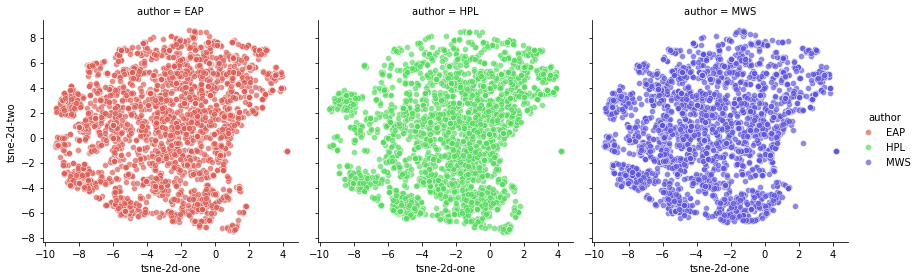

In [127]:
g = sns.FacetGrid(train, col="author", hue="author", palette=sns.color_palette("hls", 3),  height=4)
g.map(sns.scatterplot, "tsne-2d-one", "tsne-2d-two", alpha=.7)
g.add_legend()

In [121]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="author",
    palette=sns.color_palette("hls", 3),
    data=train,
    legend="full"
)

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

In [128]:
# add a tf_idf but only for proper nouns

In [132]:
import spacy
from spacy import displacy
import en_core_web_sm

NER = en_core_web_sm.load()


In [133]:
train['pos_tags'] = train.apply(lambda row: NER(row['text']), axis=1)

In [134]:
def findName(author):
    all_name=[]
    all_type=[]
    all_things=dict()
    for i in list(train[train['author']==author].pos_tags):
        for word in i.ents:
            all_name.append(word.text)
            all_type.append(word.label_)
            all_things[word.text]=word.label_

    all_person=[k for k, v in all_things.items() if v == 'PERSON' or v=='ORG' or v=='NORP' or v=='LOC']
    res_all_final=[]
    for i in all_name:
        if i in all_person:
            res_all_final.append(i)
    count_all_name=Counter(res_all_final)
    return sorted(count_all_name.items(), key=lambda x: x[1], reverse=True)[:10]

In [140]:
findName('HPL')

[('Gilman', 64),
 ('West', 55),
 ('Wilbur', 24),
 ('Pickman', 24),
 ('Carter', 21),
 ('Johansen', 19),
 ('German', 18),
 ('Musides', 18),
 ('Obed', 17),
 ('Birch', 16)]

In [136]:
findName('EAP')

[('Dupin', 56),
 ('Jupiter', 45),
 ('Marie', 38),
 ('Ellison', 27),
 ('Prefect', 25),
 ('Legrand', 23),
 ("L'Etoile", 23),
 ('Wyatt', 22),
 ('Talbot', 21),
 ('Oppodeldoc', 20)]

In [137]:
findName('MWS')

[('Raymond', 195),
 ('Adrian', 128),
 ('Idris', 90),
 ('Elizabeth', 41),
 ('Greek', 32),
 ('English', 31),
 ('Justine', 31),
 ('Clara', 31),
 ('Windsor', 30),
 ('Clerval', 25)]

## Preprocess remove punct and stop words and do phrases pre process to compute bigram:
## If 'data' 'science' will have 'data_science'

In [ ]:
# https://medium.com/@dilip.voleti/classification-using-word2vec-b1d79d375381

In [141]:
from sklearn.model_selection import train_test_split
import gensim
import re

In [35]:
stopwords_list = stopwords.words("english")

In [36]:
def clean_data(text):
    text = re.sub(r'[^ \nA-Za-z0-9À-ÖØ-öø-ÿ/]+', '', text)
    text = re.sub(r'[\\/×\^\]\[÷]', '', text)
    text = text.lower()
    final_list = [word for word in text if not word in stopwords_list]
    return text

train = train.assign(col_lemma = train.text.apply(lambda x: clean_data(x)))
train['text_with_stop_word'] = train.apply(lambda raw: nltk.word_tokenize(raw['col_lemma']), axis=1)

In [37]:
list_jsp=[]
for word in train.text_with_stop_word:
    petite_list_jsp=[]
    for i in word:
        if i not in stopwords_list:
            petite_list_jsp.append(i)
    list_jsp.append(petite_list_jsp)

In [38]:
train['tokenized_sents_final']=list_jsp

In [39]:
from gensim.models.phrases import Phrases
bigram_phrases = Phrases(train['tokenized_sents_final'], 
                         min_count=2, 
                         threshold=2)

def make_bigrams_func(text):
 
    return [bigram_phrases[doc] for doc in text]

train['Text_Tokenized_bigrams'] = make_bigrams_func(train['tokenized_sents_final'])


In [40]:
from gensim.models.phrases import Phrases
bigram_phrases = Phrases(train['text_with_stop_word'], 
                         min_count=2, 
                         threshold=2)

def make_bigrams_func(text):
 
    return [bigram_phrases[doc] for doc in text]

train['Text_Tokenized_bigrams_with_stop'] = make_bigrams_func(train['text_with_stop_word'])


In [41]:
from gensim.models.phrases import Phrases
bigram_phrases = Phrases(train['tokenized_sents'], 
                         min_count=2, 
                         threshold=2)

def make_bigrams_func(text):
 
    return [bigram_phrases[doc] for doc in text]

train['tokenized_sents_bigrams'] = make_bigrams_func(train['tokenized_sents'])


In [42]:
group=[]
for i in train.tokenized_sents_final:
    group.append(" ".join(i))
train['text_without_punct_stop']=group

In [43]:
group=[]
for i in train.tokenized_sents_bigrams:
    group.append(" ".join(i))
train['text_with_all_bigram']=group

In [45]:
stopwords_list = stopwords.words("english")

def clean_data(text):
    text = re.sub(r'[^ \nA-Za-z0-9À-ÖØ-öø-ÿ/]+', '', text)
    text = re.sub(r'[\\/×\^\]\[÷]', '', text)
    text = text.lower()
    final_list = [word for word in text if not word in stopwords_list]
    return text

test = test.assign(col_lemma = test.text.apply(lambda x: clean_data(x)))
test['text_with_stop_word'] = test.apply(lambda raw: nltk.word_tokenize(raw['col_lemma']), axis=1)

list_jsp=[]
for word in test.text_with_stop_word:
    petite_list_jsp=[]
    for i in word:
        if i not in stopwords_list:
            petite_list_jsp.append(i)
    list_jsp.append(petite_list_jsp)
    
test['tokenized_sents_final']=list_jsp

from gensim.models.phrases import Phrases
bigram_phrases = Phrases(train['tokenized_sents_final'], 
                         min_count=2, 
                         threshold=2)

def make_bigrams_func(text):
 
    return [bigram_phrases[doc] for doc in text]

test['Text_Tokenized_bigrams'] = make_bigrams_func(test['tokenized_sents_final'])

from gensim.models.phrases import Phrases
bigram_phrases = Phrases(train['text_with_stop_word'], 
                         min_count=2, 
                         threshold=2)

def make_bigrams_func(text):
 
    return [bigram_phrases[doc] for doc in text]

test['Text_Tokenized_bigrams_with_stop'] = make_bigrams_func(test['text_with_stop_word'])


from gensim.models.phrases import Phrases
bigram_phrases = Phrases(train['tokenized_sents'], 
                         min_count=2, 
                         threshold=2)

def make_bigrams_func(text):
 
    return [bigram_phrases[doc] for doc in text]

test['tokenized_sents_bigrams'] = make_bigrams_func(test['tokenized_sents'])


group=[]
for i in test.tokenized_sents_final:
    group.append(" ".join(i))
test['text_without_punct_stop']=group

group=[]
for i in test.tokenized_sents_bigrams:
    group.append(" ".join(i))
test['text_with_all_bigram']=group


In [48]:
train.to_csv('train_no_stop_words.csv', index=False)

In [49]:
test.to_csv('test_no_stop_words.csv', index=False)

In [147]:
train.head()

id                                               text author  \
0  id26305  This process, however, afforded me no means of...    EAP   
1  id17569  It never once occurred to me that the fumbling...    HPL   
2  id11008  In his left hand was a gold snuff box, from wh...    EAP   
3  id27763  How lovely is spring As we looked from Windsor...    MWS   
4  id12958  Finding nothing else, not even gold, the Super...    HPL   

                                            text_low  \
0  this process, however, afforded me no means of...   
1  it never once occurred to me that the fumbling...   
2  in his left hand was a gold snuff box, from wh...   
3  how lovely is spring as we looked from windsor...   
4  finding nothing else, not even gold, the super...   

                                     tokenized_sents  \
0  [this, process, ,, however, ,, afforded, me, n...   
1  [it, never, once, occurred, to, me, that, the,...   
2  [in, his, left, hand, was, a, gold, snuff, box...   
3  [how, lovely, is, spring, as, we, looked, from...   
4  [finding, nothing, else, ,, not, even, gold, ,...   

                                            text_all  \
0  this process , however , afforded me no means ...   
1  it never once occurred to me that the fumbling...   
2  in his left hand was a gold snuff box , from w...   
3  how lovely is spring as we looked from windsor...   
4  finding nothing else , not even gold , the sup...   

                                       without_punct  n_words  n_character  \
0  [this, process, however, afforded, me, no, mea...       48          191   
1  [it, never, once, occurred, to, me, that, the,...       15           58   
2  [in, his, left, hand, was, a, gold, snuff, box...       41          165   
3  [how, lovely, is, spring, as, we, looked, from...       38          173   
4  [finding, nothing, else, not, even, gold, the,...       31          148   

   n_punct  punct_prop  semi_colon  coma  interrogation  n_stop_words  \
0        7    0.145833           2     4              0            20   
1        1    0.066667           0     0              0             8   
2        5    0.121951           0     4              0            17   
3        4    0.105263           0     3              0            13   
4        4    0.129032           1     2              0            11   

   stop_words_prop  n_syllabe   DT    NN   RB  VBD  PRP  NNS   IN  VBG  PRP$  \
0         0.416667         68  6.0  10.0  3.0  2.0  1.0  2.0  5.0  2.0   2.0   
1         0.533333         20  2.0   2.0  2.0  1.0  2.0  0.0  1.0  0.0   0.0   
2         0.414634         56  5.0   9.0  1.0  3.0  2.0  1.0  6.0  1.0   1.0   
3         0.342105         55  2.0   6.0  1.0  2.0  1.0  4.0  6.0  0.0   0.0   
4         0.354839         52  2.0   6.0  4.0  1.0  1.0  1.0  3.0  2.0   3.0   

    MD   VB   CC  label  tsne-2d-one  tsne-2d-two  \
0  1.0  1.0  1.0      2    -7.027439     1.544742   
1  1.0  1.0  0.0      1     4.194814    -1.057997   
2  0.0  0.0  0.0      2    -0.693074     6.846798   
3  0.0  0.0  2.0      0    -0.050370     7.471983   
4  0.0  0.0  1.0      1     4.203056    -1.057204   

                                            pos_tags  
0  (This, process, ,, however, ,, afforded, me, n...  
1  (It, never, once, occurred, to, me, that, the,...  
2  (In, his, left, hand, was, a, gold, snuff, box...  
3  (How, lovely, is, spring, As, we, looked, from...  
4  (Finding, nothing, else, ,, not, even, gold, ,...

## Word2Vec

In [176]:
def word2vec(data, vector_size=200, min_count=5):
    w2v_model = gensim.models.Word2Vec(data,
                                   vector_size=vector_size,
                                   window=5,
                                   min_count=min_count)
    words = set(w2v_model.wv.index_to_key )
    X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])for ls in data], dtype=object)
            
    w2v_weights = w2v_model.wv.vectors
    vocab_size, embedding_size = w2v_weights.shape
            
    return X_train_vect, vocab_size

In [181]:
w2v_embeddings, vocab_size= word2vec(train['tokenized_sents'])

## FASTEXT

In [61]:
from gensim.models import FastText

In [62]:
def fast_text(data, label, min_count=5, vector_size=200):
    X_train, X_test, y_train, y_test = train_test_split(data, label , test_size=0.2, random_state=1000)
    
    ft_model = FastText(sentences=X_train, vector_size=vector_size, window=3, min_count=min_count)
    
    words = set(ft_model.wv.index_to_key )
    X_train_vect = np.array([np.array([ft_model.wv[i] for i in ls if i in words])
                             for ls in X_train])
    X_test_vect = np.array([np.array([ft_model.wv[i] for i in ls if i in words])for ls in X_test])
    
    X_train_vect_avg = []
    for v in X_train_vect:
        if v.size:
            X_train_vect_avg.append(v.mean(axis=0))
        else:
            X_train_vect_avg.append(np.zeros(vector_size, dtype=float))

    X_test_vect_avg = []
    for v in X_test_vect:
        if v.size:
            X_test_vect_avg.append(v.mean(axis=0))
        else:
            X_test_vect_avg.append(np.zeros(vector_size, dtype=float))
            
    return X_train_vect_avg, y_train, X_test_vect_avg, y_test

In [29]:
X_train, y_train, X_test, y_test= fast_text(train['Text_Tokenized_bigrams_with_stop'])

C:\Users\rugby\anaconda3\lib\site-packages\ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
C:\Users\rugby\anaconda3\lib\site-packages\ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if __name__ == '__main__':


## Count Vectorizer

In [36]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [37]:
def countvector(data,label, min_df=5):
    count_vectorizer = CountVectorizer(min_df=min_df)
    X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=1000)
    count_vector_train = count_vectorizer.fit_transform(X_train)
    count_vector_test = count_vectorizer.transform(X_test)
    
    return count_vector_train, y_train, count_vector_test, y_test

In [32]:
X_train, y_train, X_test, y_test= countvector(train['text_all'])

## TD-IDF

In [65]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [66]:
def tfidf(data,label, min_df=5):
    vectorizer = TfidfVectorizer(lowercase=True, token_pattern=r'(?u)\b\w*[a-zA-Z]\w*\b' ,analyzer='word', stop_words='english',min_df=min_df)
    X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=1000)
    tf_idf_train = vectorizer.fit_transform(X_train)
    tf_idf_test = vectorizer.transform(X_test)
    
    return tf_idf_train, y_train, tf_idf_test, y_test

In [35]:
X_train, y_train, X_test, y_test= tfidf(train['text_all'])

## Glove embedding:

In [37]:
# https://keras.io/examples/nlp/pretrained_word_embeddings/

In [67]:
file = open("glove.6B.100d.txt", encoding="utf8")
embeddings_dict = {}
for line in file:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [68]:
def glove_embed(data, label):
    word_embeddings = np.zeros((len(train.tokenized_sents.values), 100))
    count=0
    for word in train.tokenized_sents.values:
        for i in word:
            word_embeddings[count] = embeddings_dict.get(i, np.zeros(100))
        count+=1
    X_train, X_test, y_train, y_test = train_test_split(word_embeddings, label, test_size=0.2, random_state=1000)
    
    return X_train, y_train, X_test, y_test

## Doc2Vec

In [69]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn import utils
from tqdm import tqdm


In [70]:
def doc2vec(data, label, min_count=5, vector_size=200):
    X_train, X_test, y_train, y_test = train_test_split(data, label , test_size=0.2, random_state=1000)
    documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(X_train)]

    d2v_model = Doc2Vec(documents,
                        vector_size=vector_size,
                        window=3,
                        min_count=min_count,
                        dm=1, # 0=PV-DBOW, 1=PV-DM
                        epochs=5)
    
    words = set(d2v_model.wv.index_to_key )
    X_train_vect = np.array([np.array([d2v_model.wv[i] for i in ls if i in words])
                             for ls in X_train])
    X_test_vect = np.array([np.array([d2v_model.wv[i] for i in ls if i in words])for ls in X_test])
    
    X_train_vect_avg = []
    for v in X_train_vect:
        if v.size:
            X_train_vect_avg.append(v.mean(axis=0))
        else:
            X_train_vect_avg.append(np.zeros(vector_size, dtype=float))

    X_test_vect_avg = []
    for v in X_test_vect:
        if v.size:
            X_test_vect_avg.append(v.mean(axis=0))
        else:
            X_test_vect_avg.append(np.zeros(vector_size, dtype=float))
            
    return X_train_vect_avg, y_train, X_test_vect_avg, y_test

In [42]:
X_train, y_train, X_test, y_test= doc2vec(train['text_all'])

C:\Users\rugby\anaconda3\lib\site-packages\ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
C:\Users\rugby\anaconda3\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  from ipykernel import kernelapp as app


## Random Forest

In [163]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import mean_squared_error

In [ ]:
#Word2Vec Part:

In [ ]:
# With stop and Phrase Bigram
X_train, y_train, X_test, y_test= word2vec(train['Text_Tokenized_bigrams_with_stop'])

rf = RandomForestClassifier()
rf_model = rf.fit(X_train, y_train.values.ravel())
y_pred = rf_model.predict(X_test)

MSE = mean_squared_error(y_test, y_pred,squared = False)

round((y_pred==y_test).sum()/len(y_pred), 3)

print('MSE:'+str(MSE)+ '\n'+ 'Similarity mean: '+str(round((y_pred==y_test).sum()/len(y_pred), 3)))

In [ ]:
# Without stop and Phrase Bigram
X_train, y_train, X_test, y_test= word2vec(train['Text_Tokenized_bigrams'])

rf = RandomForestClassifier()
rf_model = rf.fit(X_train, y_train.values.ravel())
y_pred = rf_model.predict(X_test)

MSE = mean_squared_error(y_test, y_pred,squared = False)

round((y_pred==y_test).sum()/len(y_pred), 3)

print('MSE:'+str(MSE)+ '\n'+ 'Similarity mean: '+str(round((y_pred==y_test).sum()/len(y_pred), 3)))

In [ ]:
#With stop
X_train, y_train, X_test, y_test= word2vec(train['text_with_stop_word'])

rf = RandomForestClassifier()
rf_model = rf.fit(X_train, y_train.values.ravel())
y_pred = rf_model.predict(X_test)

MSE = mean_squared_error(y_test, y_pred,squared = False)

round((y_pred==y_test).sum()/len(y_pred), 3)

print('MSE:'+str(MSE)+ '\n'+ 'Similarity mean: '+str(round((y_pred==y_test).sum()/len(y_pred), 3)))

In [ ]:
# Without stop 
X_train, y_train, X_test, y_test= word2vec(train['tokenized_sents_final'])

rf = RandomForestClassifier()
rf_model = rf.fit(X_train, y_train.values.ravel())
y_pred = rf_model.predict(X_test)

MSE = mean_squared_error(y_test, y_pred,squared = False)

round((y_pred==y_test).sum()/len(y_pred), 3)

print('MSE:'+str(MSE)+ '\n'+ 'Similarity mean: '+str(round((y_pred==y_test).sum()/len(y_pred), 3)))

In [ ]:
# With everything(punct, stop, no bigram)
X_train, y_train, X_test, y_test= word2vec(train['tokenized_sents'])

rf = RandomForestClassifier()
rf_model = rf.fit(X_train, y_train.values.ravel())
y_pred = rf_model.predict(X_test)

MSE = mean_squared_error(y_test, y_pred,squared = False)

round((y_pred==y_test).sum()/len(y_pred), 3)

print('MSE:'+str(MSE)+ '\n'+ 'Similarity mean: '+str(round((y_pred==y_test).sum()/len(y_pred), 3)))

In [ ]:
# With everything(punct, stop,bigram)
X_train, y_train, X_test, y_test= word2vec(train['tokenized_sents_bigrams'])

rf = RandomForestClassifier()
rf_model = rf.fit(X_train, y_train.values.ravel())
y_pred = rf_model.predict(X_test)

MSE = mean_squared_error(y_test, y_pred,squared = False)

round((y_pred==y_test).sum()/len(y_pred), 3)

print('MSE:'+str(MSE)+ '\n'+ 'Similarity mean: '+str(round((y_pred==y_test).sum()/len(y_pred), 3)))

In [ ]:
#Count_vectorize Part:

In [ ]:
# Without punct
X_train, y_train, X_test, y_test= countvector(train['col_lemma'])

rf = RandomForestClassifier()
rf_model = rf.fit(X_train, y_train.values.ravel())
y_pred = rf_model.predict(X_test)

MSE = mean_squared_error(y_test, y_pred,squared = False)

round((y_pred==y_test).sum()/len(y_pred), 3)

print('MSE:'+str(MSE)+ '\n'+ 'Similarity mean: '+str(round((y_pred==y_test).sum()/len(y_pred), 3)))

In [57]:
# With punct
X_train, y_train, X_test, y_test= countvector(train['test_all'])

rf = RandomForestClassifier()
rf_model = rf.fit(X_train, y_train.values.ravel())
y_pred = rf_model.predict(X_test)

MSE = mean_squared_error(y_test, y_pred,squared = False)

round((y_pred==y_test).sum()/len(y_pred), 3)

print('MSE:'+str(MSE)+ '\n'+ 'Similarity mean: '+str(round((y_pred==y_test).sum()/len(y_pred), 3)))

MSE:0.8254135064247226
Similarity mean: 0.698


In [ ]:
# Without punct, stop
X_train, y_train, X_test, y_test= countvector(train['text_without_punct_stop'])

rf = RandomForestClassifier()
rf_model = rf.fit(X_train, y_train.values.ravel())
y_pred = rf_model.predict(X_test)

MSE = mean_squared_error(y_test, y_pred,squared = False)

round((y_pred==y_test).sum()/len(y_pred), 3)

print('MSE:'+str(MSE)+ '\n'+ 'Similarity mean: '+str(round((y_pred==y_test).sum()/len(y_pred), 3)))

In [ ]:
# With all and bigram
X_train, y_train, X_test, y_test= countvector(train['text_with_all_bigram'])

rf = RandomForestClassifier()
rf_model = rf.fit(X_train, y_train.values.ravel())
y_pred = rf_model.predict(X_test)

MSE = mean_squared_error(y_test, y_pred,squared = False)

round((y_pred==y_test).sum()/len(y_pred), 3)

print('MSE:'+str(MSE)+ '\n'+ 'Similarity mean: '+str(round((y_pred==y_test).sum()/len(y_pred), 3)))

In [ ]:
#TF_IDF Part:

In [ ]:
# Without punct
X_train, y_train, X_test, y_test= tfidf(train['col_lemma'])

rf = RandomForestClassifier()
rf_model = rf.fit(X_train, y_train.values.ravel())
y_pred = rf_model.predict(X_test)

MSE = mean_squared_error(y_test, y_pred,squared = False)

round((y_pred==y_test).sum()/len(y_pred), 3)

print('MSE:'+str(MSE)+ '\n'+ 'Similarity mean: '+str(round((y_pred==y_test).sum()/len(y_pred), 3)))

In [ ]:
# With punct
X_train, y_train, X_test, y_test= tfidf(train['test_all'])

rf = RandomForestClassifier()
rf_model = rf.fit(X_train, y_train.values.ravel())
y_pred = rf_model.predict(X_test)

MSE = mean_squared_error(y_test, y_pred,squared = False)

round((y_pred==y_test).sum()/len(y_pred), 3)

print('MSE:'+str(MSE)+ '\n'+ 'Similarity mean: '+str(round((y_pred==y_test).sum()/len(y_pred), 3)))

In [ ]:
# Without punct, stop
X_train, y_train, X_test, y_test= tfidf(train['text_without_punct_stop'])

rf = RandomForestClassifier()
rf_model = rf.fit(X_train, y_train.values.ravel())
y_pred = rf_model.predict(X_test)

MSE = mean_squared_error(y_test, y_pred,squared = False)

round((y_pred==y_test).sum()/len(y_pred), 3)

print('MSE:'+str(MSE)+ '\n'+ 'Similarity mean: '+str(round((y_pred==y_test).sum()/len(y_pred), 3)))

In [ ]:
# With all and bigram
X_train, y_train, X_test, y_test= tfidf(train['text_with_all_bigram'])

rf = RandomForestClassifier()
rf_model = rf.fit(X_train, y_train.values.ravel())
y_pred = rf_model.predict(X_test)

MSE = mean_squared_error(y_test, y_pred,squared = False)

round((y_pred==y_test).sum()/len(y_pred), 3)

print('MSE:'+str(MSE)+ '\n'+ 'Similarity mean: '+str(round((y_pred==y_test).sum()/len(y_pred), 3)))

In [ ]:
#Doc2Vec Part:

In [ ]:
# With stop and Phrase Bigram
X_train, y_train, X_test, y_test= doc2vec(train['Text_Tokenized_bigrams_with_stop'])

rf = RandomForestClassifier()
rf_model = rf.fit(X_train, y_train.values.ravel())
y_pred = rf_model.predict(X_test)

MSE = mean_squared_error(y_test, y_pred,squared = False)

round((y_pred==y_test).sum()/len(y_pred), 3)

print('MSE:'+str(MSE)+ '\n'+ 'Similarity mean: '+str(round((y_pred==y_test).sum()/len(y_pred), 3)))

In [ ]:
# Without stop and Phrase Bigram
X_train, y_train, X_test, y_test= doc2vec(train['Text_Tokenized_bigrams'])

rf = RandomForestClassifier()
rf_model = rf.fit(X_train, y_train.values.ravel())
y_pred = rf_model.predict(X_test)

MSE = mean_squared_error(y_test, y_pred,squared = False)

round((y_pred==y_test).sum()/len(y_pred), 3)

print('MSE:'+str(MSE)+ '\n'+ 'Similarity mean: '+str(round((y_pred==y_test).sum()/len(y_pred), 3)))

In [ ]:
#With stop
X_train, y_train, X_test, y_test= doc2vec(train['text_with_stop_word'])

rf = RandomForestClassifier()
rf_model = rf.fit(X_train, y_train.values.ravel())
y_pred = rf_model.predict(X_test)

MSE = mean_squared_error(y_test, y_pred,squared = False)

round((y_pred==y_test).sum()/len(y_pred), 3)

print('MSE:'+str(MSE)+ '\n'+ 'Similarity mean: '+str(round((y_pred==y_test).sum()/len(y_pred), 3)))

In [ ]:
# With everything(punct, stop, no bigram)
X_train, y_train, X_test, y_test= doc2vec(train['tokenized_sents'])

rf = RandomForestClassifier()
rf_model = rf.fit(X_train, y_train.values.ravel())
y_pred = rf_model.predict(X_test)

MSE = mean_squared_error(y_test, y_pred,squared = False)

round((y_pred==y_test).sum()/len(y_pred), 3)

print('MSE:'+str(MSE)+ '\n'+ 'Similarity mean: '+str(round((y_pred==y_test).sum()/len(y_pred), 3)))

In [ ]:
# With everything(punct, stop,bigram)
X_train, y_train, X_test, y_test= doc2vec(train['tokenized_sents_bigrams'])

rf = RandomForestClassifier()
rf_model = rf.fit(X_train, y_train.values.ravel())
y_pred = rf_model.predict(X_test)

MSE = mean_squared_error(y_test, y_pred,squared = False)

round((y_pred==y_test).sum()/len(y_pred), 3)

print('MSE:'+str(MSE)+ '\n'+ 'Similarity mean: '+str(round((y_pred==y_test).sum()/len(y_pred), 3)))

In [ ]:
## Fast Text

In [ ]:
# With stop and Phrase Bigram
X_train, y_train, X_test, y_test= fast_text(train['Text_Tokenized_bigrams_with_stop'])

rf = RandomForestClassifier()
rf_model = rf.fit(X_train, y_train.values.ravel())
y_pred = rf_model.predict(X_test)

MSE = mean_squared_error(y_test, y_pred,squared = False)

round((y_pred==y_test).sum()/len(y_pred), 3)

print('MSE:'+str(MSE)+ '\n'+ 'Similarity mean: '+str(round((y_pred==y_test).sum()/len(y_pred), 3)))

In [ ]:
# With everything(punct, stop,bigram)
X_train, y_train, X_test, y_test= fast_text(train['tokenized_sents_bigrams'])

rf = RandomForestClassifier()
rf_model = rf.fit(X_train, y_train.values.ravel())
y_pred = rf_model.predict(X_test)

MSE = mean_squared_error(y_test, y_pred,squared = False)

round((y_pred==y_test).sum()/len(y_pred), 3)

print('MSE:'+str(MSE)+ '\n'+ 'Similarity mean: '+str(round((y_pred==y_test).sum()/len(y_pred), 3)))

In [ ]:
## Glove

In [ ]:
# With everything(punct, stop, no bigram)
X_train, y_train, X_test, y_test= glove_embed(train['tokenized_sents'])

rf = RandomForestClassifier()
rf_model = rf.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

MSE = mean_squared_error(y_test, y_pred,squared = False)

round((y_pred==y_test).sum()/len(y_pred), 3)

print('MSE:'+str(MSE)+ '\n'+ 'Similarity mean: '+str(round((y_pred==y_test).sum()/len(y_pred), 3)))

In [ ]:
# With stop and Phrase Bigram
X_train, y_train, X_test, y_test= glove_embed(train['Text_Tokenized_bigrams_with_stop'])

rf = RandomForestClassifier()
rf_model = rf.fit(X_train, y_train.values.ravel())
y_pred = rf_model.predict(X_test)

MSE = mean_squared_error(y_test, y_pred,squared = False)

round((y_pred==y_test).sum()/len(y_pred), 3)

print('MSE:'+str(MSE)+ '\n'+ 'Similarity mean: '+str(round((y_pred==y_test).sum()/len(y_pred), 3)))

In [ ]:
# With everything(punct, stop,bigram)
X_train, y_train, X_test, y_test= glove_embed(train['tokenized_sents_bigrams'])

rf = RandomForestClassifier()
rf_model = rf.fit(X_train, y_train.values.ravel())
y_pred = rf_model.predict(X_test)

MSE = mean_squared_error(y_test, y_pred,squared = False)

round((y_pred==y_test).sum()/len(y_pred), 3)

print('MSE:'+str(MSE)+ '\n'+ 'Similarity mean: '+str(round((y_pred==y_test).sum()/len(y_pred), 3)))

In [ ]:
## Logistice Regression

In [44]:
from sklearn.linear_model import LogisticRegression

In [46]:
classifier = LogisticRegression()
X_train, y_train, X_test, y_test= glove_embed(train['Text_Tokenized_bigrams_with_stop'])
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)
score

0.41266598569969354

In [53]:
classifier = LogisticRegression()
X_train, y_train, X_test, y_test= word2vec(train['tokenized_sents'])
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)
score

C:\Users\rugby\anaconda3\lib\site-packages\ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
C:\Users\rugby\anaconda3\lib\site-packages\ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if __name__ == '__main__':
C:\Users\rugby\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/mod

0.5850357507660878

In [55]:
classifier = LogisticRegression()
X_train, y_train, X_test, y_test= countvector(train['test_all'])
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)
score

C:\Users\rugby\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.8197139938712973

## Predict exclamation

In [23]:
from nltk.tokenize import sent_tokenize


file = open('all_text.txt', encoding="utf8")
all_text=file.read()
all_text=sent_tokenize(all_text)

all_author=pd.DataFrame(all_text,columns=['text'])
all_author['author']=all_author.shape[0]*['all_text']

all_author['tokenized_sents'] = all_author.apply(lambda raw: nltk.word_tokenize(raw['text']), axis=1)

compare='!'
list_punct=[]
for i in all_author.tokenized_sents.values:
    cam=0
    for j in i:
        if j==compare:
            cam=1
    list_punct.append(cam)
all_author['exclamation']=list_punct


without_exclamation = all_author[all_author['exclamation']==0].sample(n = all_author.groupby('exclamation').count().reset_index().text[1:2].values[0], random_state = 44)
all_author=pd.concat([without_exclamation,all_author[all_author['exclamation']==1]])


KeyboardInterrupt: 

In [32]:
all_author_sample['without_punct']=all_author_sample['tokenized_sents'].apply(lambda x: [item for item in x if item != '!'])

In [33]:
group=[]
for i in all_author_sample.without_punct:
    group.append(" ".join(i))
all_author_sample['text_without_punct']=group

In [34]:
all_author_sample

text    author  \
15768  The bent, goatish giant before him seemed like...  all_text   
11953                            Cavalier was acquitted.  all_text   
10284  As long as it is for the magistrate, I can't.”...  all_text   
16256  It was not a matter of old legendry at all, bu...  all_text   
13072  The barometers mark twelve hundred metres, the...  all_text   
...                                                  ...       ...   
19016   mysterious, ill-visaged friend of weak humanity!  all_text   
19018                    Oh, for the peace of the grave!  all_text   
19019           the deep silence of the iron-bound tomb!  all_text   
19020  that thought would cease to work in my brain, ...  all_text   
19032                                              Fool!  all_text   

                                         tokenized_sents  exclamation  \
15768  [The, bent, ,, goatish, giant, before, him, se...            0   
11953                      [Cavalier, was, acquitted, .]            0   
10284  [As, long, as, it, is, for, the, magistrate, ,...            0   
16256  [It, was, not, a, matter, of, old, legendry, a...            0   
13072  [The, barometers, mark, twelve, hundred, metre...            0   
...                                                  ...          ...   
19016  [mysterious, ,, ill-visaged, friend, of, weak,...            1   
19018        [Oh, ,, for, the, peace, of, the, grave, !]            1   
19019  [the, deep, silence, of, the, iron-bound, tomb...            1   
19020  [that, thought, would, cease, to, work, in, my...            1   
19032                                          [Fool, !]            1   

                                           without_punct  \
15768  [The, bent, ,, goatish, giant, before, him, se...   
11953                      [Cavalier, was, acquitted, .]   
10284  [As, long, as, it, is, for, the, magistrate, ,...   
16256  [It, was, not, a, matter, of, old, legendry, a...   
13072  [The, barometers, mark, twelve, hundred, metre...   
...                                                  ...   
19016  [mysterious, ,, ill-visaged, friend, of, weak,...   
19018           [Oh, ,, for, the, peace, of, the, grave]   
19019    [the, deep, silence, of, the, iron-bound, tomb]   
19020  [that, thought, would, cease, to, work, in, my...   
19032                                             [Fool]   

                                      text_without_punct  
15768  The bent , goatish giant before him seemed lik...  
11953                           Cavalier was acquitted .  
10284  As long as it is for the magistrate , I can't....  
16256  It was not a matter of old legendry at all , b...  
13072  The barometers mark twelve hundred metres , th...  
...                                                  ...  
19016   mysterious , ill-visaged friend of weak humanity  
19018                    Oh , for the peace of the grave  
19019            the deep silence of the iron-bound tomb  
19020  that thought would cease to work in my brain ,...  
19032                                               Fool  

[3614 rows x 6 columns]

In [192]:
import tensorflow as tf

In [276]:
# X_train, y_train, X_test, y_test= countvector(all_author_sample['text_without_punct'], all_author_sample.exclamation)
# X_train, y_train, X_test, y_test= tfidf(all_author['text_without_punct'], all_author.exclamation)


In [ ]:
## LSTM

In [280]:
# model = Sequential()
# model.add(Embedding(5000, 300, input_length=X_train.toarray().shape[1]))
# model.add(LSTM(100, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(100))
# model.add(Dropout(0.3))
# model.add(Dense(1, activation='sigmoid'))
# # model.add(LSTM(100))
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [281]:
# model.fit(X_train.toarray(), np.array(y_train), epochs=3)

Epoch 1/3
65/91 [====================>.........] - ETA: 39s - loss: 0.6942 - accuracy: 0.5144

KeyboardInterrupt: 

In [188]:
# test_loss, test_acc = model.evaluate(X_test.toarray(), y_test)
# test_loss, test_acc

0.690280020236969

In [ ]:
## RNN

In [296]:
count_vectorizer = CountVectorizer(min_df=5)
X_train, X_test, y_train, y_test = train_test_split(all_author_sample['text_without_punct'],  all_author_sample.exclamation, test_size=0.2, random_state=1000)
X_train = count_vectorizer.fit_transform(X_train)
X_test = count_vectorizer.transform(X_test)

In [297]:
model = tf.keras.Sequential()
model.add(Embedding(input_dim=5000, output_dim=100, input_length=X_train.toarray().shape[1]))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(2, activation='softmax'))

In [298]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [299]:
history_rnn = model.fit(X_train.toarray(), np.array(tf.keras.utils.to_categorical(y_train)), epochs=5, batch_size=32,validation_data=(X_test.toarray(), np.array(tf.keras.utils.to_categorical(y_test))))

Epoch 1/5
91/91 [==============================] - 7s 67ms/step - loss: 0.6409 - accuracy: 0.6271 - val_loss: 0.6127 - val_accuracy: 0.6943
Epoch 2/5
91/91 [==============================] - 7s 74ms/step - loss: 0.5045 - accuracy: 0.7593 - val_loss: 0.5988 - val_accuracy: 0.7082
Epoch 3/5
91/91 [==============================] - 5s 60ms/step - loss: 0.4336 - accuracy: 0.8049 - val_loss: 0.6227 - val_accuracy: 0.7109
Epoch 4/5
91/91 [==============================] - 6s 60ms/step - loss: 0.3897 - accuracy: 0.8246 - val_loss: 0.6589 - val_accuracy: 0.7095
Epoch 5/5
91/91 [==============================] - 6s 69ms/step - loss: 0.3573 - accuracy: 0.8402 - val_loss: 0.7297 - val_accuracy: 0.7137


In [300]:
test_loss, test_acc = model.evaluate(X_test.toarray(), tf.keras.utils.to_categorical(y_test))

23/23 [==============================] - 1s 25ms/step - loss: 0.7297 - accuracy: 0.7137


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


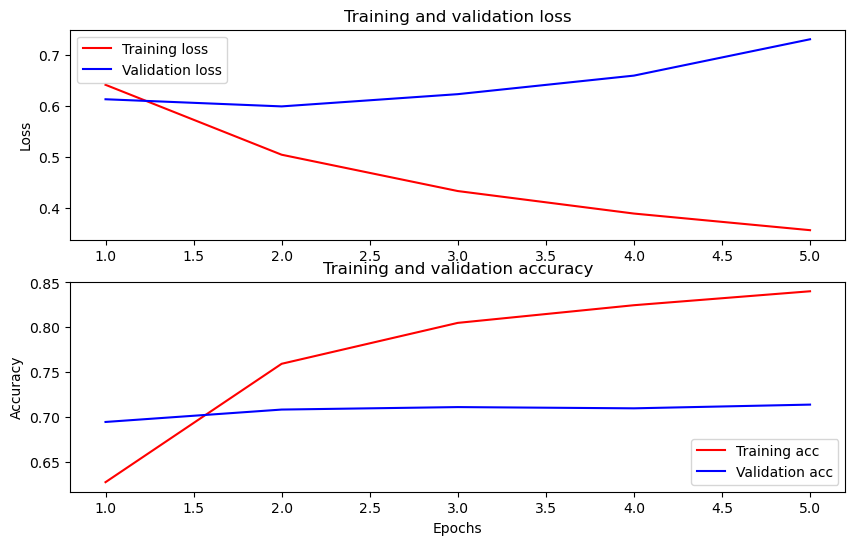

In [301]:
history_dict = history_rnn.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [302]:
y_pred=model.predict(X_test.toarray())

23/23 [==============================] - 0s 14ms/step


In [303]:
y_pred=list(np.argmax(y_pred, axis=1))

In [304]:
mean_squared_error(y_test, y_pred)

0.2863070539419087

In [366]:
train_data_exclamation=count_vectorizer.transform(train['text'])
exclamation_train = model.predict(train_data_exclamation.toarray())
train['exclamation']=np.argmax(exclamation_train,axis=1)
train['text_token_exclamation'] = train.apply(lambda raw: nltk.word_tokenize(raw['text']), axis=1)
without_mark=train[train['exclamation']==1].text_token_exclamation.apply(lambda x: [item for item in x if item != '.'])
for i in without_mark:
    i.insert(len(i),'!')
train.loc[train['exclamation']==1,'text_token_exclamation']=without_mark


group=[]
for i in train.text_token_exclamation:
    group.append(" ".join(i))
train['text_exclamation']=group

612/612 [==============================] - 11s 18ms/step


In [368]:
test_data_exclamation=count_vectorizer.transform(test['text'])
exclamation_test = model.predict(test_data_exclamation.toarray())
test['exclamation']=np.argmax(exclamation_test,axis=1)
test['text_token_exclamation'] = test.apply(lambda raw: nltk.word_tokenize(raw['text']), axis=1)
without_mark=test[test['exclamation']==1].text_token_exclamation.apply(lambda x: [item for item in x if item != '.'])
for i in without_mark:
    i.insert(len(i),'!')
test.loc[test['exclamation']==1,'text_token_exclamation']=without_mark

group=[]
for i in test.text_token_exclamation:
    group.append(" ".join(i))
test['text_exclamation']=group

263/263 [==============================] - 4s 17ms/step


## BERT

In [58]:
import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tensorflow
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.preprocessing import MaxAbsScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import log_loss, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [62]:
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization

In [ ]:
### You maybe need to download this package if you don't havz

In [1]:
# pip install tensorflow-hub

  Using cached tensorflow_hub-0.12.0-py2.py3-none-any.whl (108 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
# pip install -q -U tensorflow-text

Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
rpunct 1.0.2 requires pandas==1.2.4, but you have pandas 1.3.5 which is incompatible.
mxnet 1.7.0.post2 requires numpy<1.17.0,>=1.8.2, but you have numpy 1.21.6 which is incompatible.
mxnet 1.7.0.post2 requires requests<2.19.0,>=2.18.4, but you have requests 2.28.1 which is incompatible.


In [3]:
# pip install -q -U tf-models-official

Note: you may need to restart the kernel to use updated packages.


In [63]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

In [64]:
def build_classifier_model():
    text_input = tensorflow.keras.layers.Input(shape=(), dtype=tensorflow.string, name='test_all')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tensorflow.keras.layers.Dropout(0.1)(net)
    net = tensorflow.keras.layers.Dense(3, activation='softmax', name='classifier_b')(net)
    return tensorflow.keras.Model(text_input, net)

In [65]:
classifier_model = build_classifier_model()

In [116]:
X_train, X_test = train_test_split(train, test_size=0.30, stratify=train['label'], random_state=1234)

In [117]:
def df_to_dataset(dataframe, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('label')
    ds = tensorflow.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.batch(batch_size)
    return ds

In [118]:
train_ds  = df_to_dataset(X_train[['test_all','label']], batch_size=32)
test_ds  = df_to_dataset(X_test[['test_all','label']], batch_size=32)

In [119]:
epochs = 5
steps_per_epoch = tensorflow.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [122]:
classifier_model.compile(optimizer=optimizer,
                         loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'])

In [124]:
history = classifier_model.fit(x=train_ds, validation_data=test_ds, batch_size=32, epochs=3)

Epoch 1/3
429/429 [==============================] - 3041s 7s/step - loss: 0.7720 - accuracy: 0.6448 - val_loss: 0.5465 - val_accuracy: 0.7773
Epoch 2/3
429/429 [==============================] - 2901s 7s/step - loss: 0.4491 - accuracy: 0.8229 - val_loss: 0.4880 - val_accuracy: 0.8131
Epoch 3/3
429/429 [==============================] - 2737s 6s/step - loss: 0.3137 - accuracy: 0.8813 - val_loss: 0.5083 - val_accuracy: 0.8231


In [126]:
classifier_model.evaluate(train_ds, batch_size=32)

429/429 [==============================] - 505s 1s/step - loss: 0.1874 - accuracy: 0.9310


[0.18744634091854095, 0.9309741258621216]

In [127]:
classifier_model.evaluate(test_ds, batch_size=32)

184/184 [==============================] - 213s 1s/step - loss: 0.5083 - accuracy: 0.8231


[0.5082707405090332, 0.8231188058853149]

In [161]:
for i in list(X_test['label'].values):
    if i==3:
        print(i)

In [162]:
for i in list(all_pred):
    if i==3:
        print(i)


In [164]:
mean_squared_error(list(X_test['label'].values), list(all_pred))

0.4153898535921008

In [125]:
classifier_model.save("mnist_model.h5")

In [166]:
history_dict

{'loss': [0.7720048427581787, 0.44907328486442566, 0.3136748671531677],
 'accuracy': [0.644801139831543, 0.8229113221168518, 0.8812841773033142],
 'val_loss': [0.5464544892311096, 0.487967312335968, 0.5082707405090332],
 'val_accuracy': [0.7773237824440002, 0.8130745887756348, 0.8231188058853149]}

In [171]:
import matplotlib.pyplot as plt

In [172]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [14]:
### This part just appply same things than for train

In [178]:
dep_preds = classifier_model.predict(test['test_all'].values)
dep_df = pd.DataFrame(data=dep_preds, columns=['EAP','MWS','HPL'])

263/263 [==============================] - 305s 1s/step


In [182]:
dep_df

EAP       MWS       HPL
0     0.999081  0.000573  0.000346
1     0.000254  0.001932  0.997815
2     0.001253  0.998649  0.000098
3     0.214421  0.062381  0.723198
4     0.112454  0.448526  0.439019
...        ...       ...       ...
8387  0.250059  0.029979  0.719962
8388  0.922301  0.000951  0.076747
8389  0.002236  0.281719  0.716045
8390  0.990026  0.008642  0.001332
8391  0.001137  0.768857  0.230006

[8392 rows x 3 columns]

## ML PART

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression
from sklearn import svm

In [ ]:
def all_token(data, algorithme):
    X_train_word2vec, y_train_word2vec, X_test_word2vec, y_test_word2vec= word2vec(data,train['label'])
    X_train_glove, y_train_glove, X_test_glove, y_test_glove= glove_embed(data,train['label'])
    X_train_fasttext, y_train_fasttext, X_test_fasttext, y_test_fasttext= fast_text(data,train['label'])
    X_train_doc2vec, y_train_doc2vec, X_test_doc2vec, y_test_doc2vec = doc2vec(data,train['label'])
    
    classifier = algorithme
    classifier.fit(X_train_word2vec, y_train_word2vec)
    score = classifier.score(X_test_word2vec, y_test_word2vec)
    print('Word2Vec Accuracy is: '+str(score*100))
    
    classifier = algorithme
    classifier.fit(X_train_doc2vec, y_train_doc2vec)
    score = classifier.score(X_test_doc2vec, y_test_doc2vec)
    print('Doc2Vec Accuracy is: '+str(score*100))
    
    classifier = algorithme
    classifier.fit(X_train_glove, y_train_glove)
    score = classifier.score(X_test_glove, y_test_glove)
    print('Glove Accuracy is: '+str(score*100))
    
    classifier = algorithme
    classifier.fit(X_train_fasttext, y_train_fasttext)
    score = classifier.score(X_test_fasttext, y_test_fasttext)
    print('Fast Text Accuracy is: '+str(score*100))

In [ ]:
def all_text(data, algorithme):
    X_train_countvector, y_train_countvector, X_test_countvector, y_test_countvector= countvector(data,train['label'])
    X_train_tfidf, y_train_tfidf, X_test_tfidf, y_test_tfidf= tfidf(data,train['label'])
    
    classifier = algorithme
    classifier.fit(X_train_countvector, y_train_countvector)
    score = classifier.score(X_test_countvector, y_test_countvector)
    print('CountVector Accuracy is: '+str(score*100))
    
    classifier = algorithme
    classifier.fit(X_train_tfidf, y_train_tfidf)
    score = classifier.score(X_test_tfidf, y_test_tfidf)
    print('TF-IDF Accuracy is: '+str(score*100))

In [ ]:
## Logistic Regression
print('Texte de base')
all_token(train['text'], LogisticRegression(max_iter=1000))
all_text(train.test_all, LogisticRegression(max_iter=1000))

print('Texte sans punctuation')
all_token(train['without_punct'], LogisticRegression(max_iter=1000))
all_text(train.col_lemma, LogisticRegression(max_iter=1000))

print('Texte With-bigrams')
all_token(train['tokenized_sents_bigrams'], LogisticRegression(max_iter=1000))
all_text(train.text_with_all_bigram, LogisticRegression(max_iter=1000))

print('Texte Esclamation-mark')
all_token(train['text_token_exclamation'], LogisticRegression(max_iter=1000))
all_text(train.text_exclamation, LogisticRegression(max_iter=1000))

In [ ]:
# Random_forest
print('Texte de base')
all_token(train['text'], RandomForestClassifier())
all_text(train.test_all,RandomForestClassifier())

print('Texte sans punctuation')
all_token(train['without_punct'],RandomForestClassifier())
all_text(train.col_lemma,RandomForestClassifier())

print('Texte With-bigrams')
all_token(train['tokenized_sents_bigrams'], RandomForestClassifier())
all_text(train.text_with_all_bigram, RandomForestClassifier())

print('Texte Esclamation-mark')
all_token(train['text_token_exclamation'], RandomForestClassifier())
all_text(train.text_exclamation, RandomForestClassifier())

In [ ]:
# SVM
print('Texte de base')
all_token(train['text'], svm.SVC())
all_text(train.test_all, svm.SVC())

print('Texte sans punctuation')
all_token(train['without_punct'], svm.SVC())
all_text(train.col_lemma, svm.SVC())

print('Texte With-bigrams')
all_token(train['tokenized_sents_bigrams'], svm.SVC())
all_text(train.text_with_all_bigram, svm.SVC())

print('Texte Esclamation-mark')
all_token(train['text_token_exclamation'], svm.SVC())
all_text(train.text_exclamation, svm.SVC())